# Imports

In [ ]:
import re
from typing import Dict, List, Optional, Text, Tuple
import matplotlib.pyplot as plt
from matplotlib import colors

import tensorflow as tf
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, Activation
from tensorflow.keras.metrics import AUC
from tensorflow.keras.optimizers import Adam

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# Load the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
path_to_arrays = "/content/drive/My Drive/mit/cv_project/data/data2" # create a shortcut from my files to your drive and put the path here
path_train = os.path.join(path_to_arrays, "train.npy")
path_train_labels = os.path.join(path_to_arrays, "train_labels.npy")
features = np.load(path_train)
labels = np.load(path_train_labels)

path_val = os.path.join(path_to_arrays, "val.npy")
path_val_labels = os.path.join(path_to_arrays, "val_labels.npy")
val_features = np.load(path_val)
val_labels = np.load(path_val_labels)

path_test = os.path.join(path_to_arrays, "test.npy")
path_test_labels = os.path.join(path_to_arrays, "test_labels.npy")
test_features = np.load(path_test)
test_labels = np.load(path_test_labels)

In [ ]:
features.shape

(2803, 32, 32, 12)

In [ ]:
features[0][0][0]

array([ 9.8300000e+02, -6.1656392e-01,  2.8613334e+00,  2.9254208e+02,
        3.0978613e+02,  6.9211517e-03,  0.0000000e+00, -1.5406020e+00,
        7.5210000e+03,  0.0000000e+00,  8.1897675e+01,  0.0000000e+00],
      dtype=float32)

# Dummy Model: Predict the same fire mask as previous-day

In [ ]:
(num_samples, r, r, num_features) = test_features.shape

dummy_predictions = np.zeros(shape=(num_samples,r,r,1))
for i in range(num_samples):
  dummy_predictions[i,:,:,:] = test_features[i,:,:,11:]

In [ ]:
from sklearn.metrics import roc_auc_score

y_true_flat = test_labels.ravel()
y_scores_flat = dummy_predictions.ravel()

auc = roc_auc_score(y_true_flat, y_scores_flat)
print("AUC:", auc)

AUC: 0.6770238623307233


# Predict next day fire masks

### Benchmark: linear regression & logistic regression

In [ ]:
def flatten(final_certain_input_array, final_certain_labels):
  """ Returns flat inputs and flat labels for linear models"""
  flat_features = []
  flat_labels = []
  for var in range(final_certain_input_array.shape[2]):
    flat_feature = []
    for obs in range(final_certain_input_array.shape[3]):
      for row in range(final_certain_input_array.shape[0]):
          for col in range(final_certain_input_array.shape[1]):
              flat_feature.append(final_certain_input_array[row, col, var, obs])
    flat_features.append(np.array(flat_feature))

  for obs in range(final_certain_labels.shape[2]):
    for row in range(final_certain_labels.shape[0]):
        for col in range(final_certain_labels.shape[1]):
            flat_labels.append(final_certain_labels[row, col, obs])
  flat_labels = np.array(flat_labels)
  return flat_features, flat_labels

In [ ]:
flat_features, flat_labels = flatten(final_certain_input_array, final_certain_labels)
val_flat_features, val_flat_labels = flatten(val_final_certain_input_array, val_final_certain_labels)
test_flat_features, test_flat_labels = flatten(test_final_certain_input_array, test_final_certain_labels)

In [ ]:
X_train = np.vstack([np.transpose(feature) for feature in flat_features])
X_train = np.transpose(X_train) #so that observations correspond to rows now
Y_train = flat_labels

X_val = np.vstack([np.transpose(feature) for feature in val_flat_features])
X_val = np.transpose(X_val)
Y_val = val_flat_labels

X_test = np.vstack([np.transpose(feature) for feature in test_flat_features])
X_test = np.transpose(X_test)
Y_test = test_flat_labels

In [ ]:
# standardize because the units are NOT the same for the inputs
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

In [ ]:
#Benchmark method: Try linear regression

variables = [  'Elevation',
  'Wind\ndirection',
  'Wind\nvelocity',
  'Min\ntemp',
  'Max\ntemp',
  'Humidity',
  'Precip',
  'Drought',
  'Vegetation',
  'Population\ndensity',
  'Energy\nrelease\ncomponent',
  'Previous\nfire\nmask',
  'Fire\nmask']

#Regression time!
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

lr_fire = LinearRegression().fit(X_train_scaled, Y_train)

print('training R2-score:', np.round(   r2_score(  Y_train, lr_fire.predict(X_train_scaled)),2  )   )

scores_fire = cross_val_score(lr_fire, X_train_scaled, Y_train, cv=10, scoring='r2')

print("validation R2-scores:",np.round(scores_fire,2))
print("average:", np.round(np.mean(scores_fire),2))

print('LR coefficients:')
for i, coeff in enumerate(lr_fire.coef_):
    print('{0:5s}  {1:>-10.2f}'.format(variables[i], np.round(coeff,2)))


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, Y_train)

# Prediction and Evaluation
Y_pred = log_reg.predict(X_train_scaled)
print('Training accuracy:', accuracy_score(Y_train, Y_pred))
print('Classification report:\n', classification_report(Y_train, Y_pred))

# Cross-validation
scores_accuracy = cross_val_score(log_reg, X_train_scaled, Y_train, cv=10, scoring='accuracy')
print("Validation accuracy scores:", np.round(scores_accuracy, 2))
print("Average accuracy:", np.round(np.mean(scores_accuracy), 2))

print('Logistic Regression coefficients:')
for i, coeff in enumerate(log_reg.coef_[0]):
    print('{0:30s} {1:>-10.2f}'.format(variables[i], coeff))


### Simple CNN

In [ ]:
CNN = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 12)),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu'),
    Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu'),
    Conv2D(1, (1, 1), activation='sigmoid', padding='same')
])
optimizer = Adam(learning_rate=0.0001)
CNN.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', AUC(name='auc')])
CNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        3488      
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 conv2d_transpose (Conv2DTr  (None, 16, 16, 128)       1

In [ ]:
history_CNN = CNN.fit(features, labels, epochs=30, batch_size=16, validation_data=(val_features, val_labels))

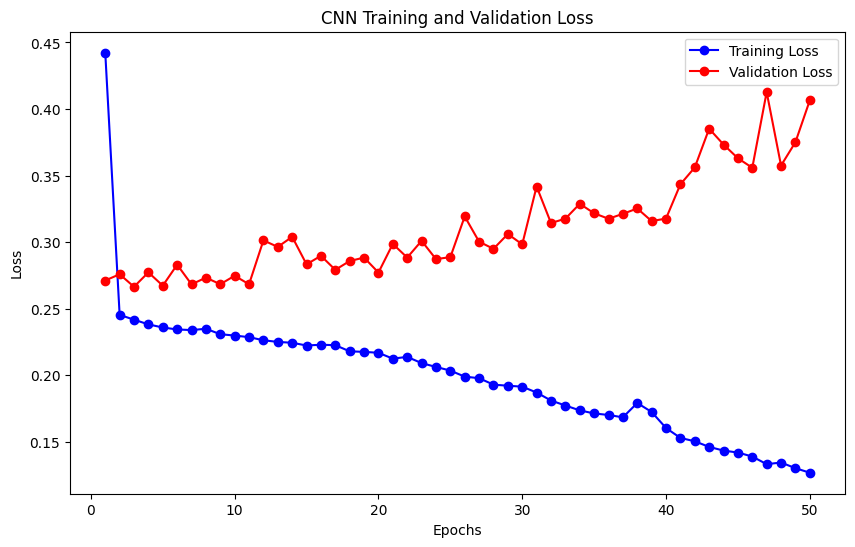

In [ ]:
import matplotlib.pyplot as plt
loss = history_CNN.history['loss']
val_loss = history_CNN.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(10, 6))  # Optional: Adjusts the size of the plot
plt.plot(epochs, loss, label='Training Loss', color='blue', marker='o')
if val_loss is not None:
    plt.plot(epochs, val_loss, label='Validation Loss', color='red', marker='o')

plt.title('CNN Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# plt.grid(True)  # Optional: Adds a grid for easier reading
plt.show()

In [ ]:
# Evaluate on test set
scores = CNN.evaluate(test_features, test_labels)
print(f'Test Loss: {scores[0]}, Test Accuracy: {scores[1]}, Test AUC: {scores[2]}')

11/11 [==============================] - 1s 23ms/step - loss: 0.2602 - accuracy: 0.9290 - auc: 0.6976
Test Loss: 0.2601945400238037, Test Accuracy: 0.9289951324462891, Test AUC: 0.6976168751716614


In [ ]:
# Predictions sur X_train pour voir si déjà ça ça marche (ça marche pas)
predicted_masks_CNN = CNN.predict(test_features)

11/11 [==============================] - 0s 4ms/step


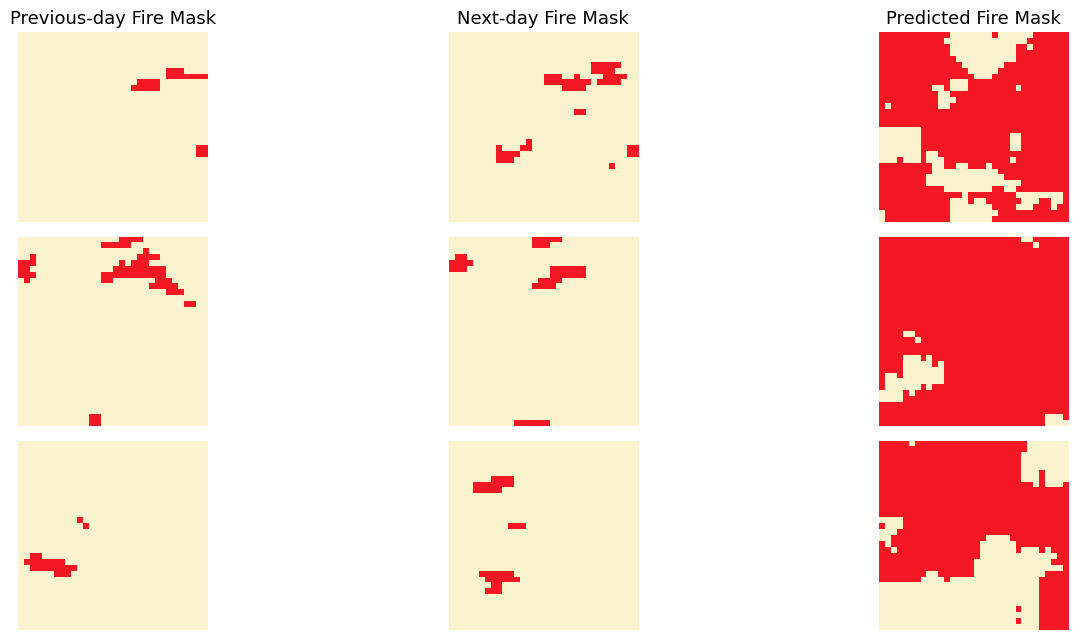

In [ ]:
TITLES_pred = ["Previous-day Fire Mask", "Next-day Fire Mask","Predicted Fire Mask"]
fig = plt.figure(figsize=(15,6.5))
n_rows = 3
CMAP = colors.ListedColormap(['black', "#FAF3CE", '#F41724'])
BOUNDS = [-1, -0.1, 0.001, 1]
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)

for i in range(n_rows):
  for j in range(3):
    plt.subplot(n_rows, 3, i * (3) + j + 1)
    if i == 0:
      plt.title(TITLES_pred[j], fontsize=13)
    if j == 0:
      plt.imshow(test_features[i, :, :, 11], cmap=CMAP, norm=NORM)
    if j == 1:
      plt.imshow(test_labels[i, :, :, 0], cmap=CMAP, norm=NORM)
    if j == 2:
      plt.imshow(predicted_masks_CNN[i,:,:], cmap=CMAP, norm=NORM)
    plt.axis('off')
plt.tight_layout()

### Weighted cross-entropy loss
Different weights on the ‘fire’ labels to take into account
the class imbalance

In [ ]:
!pip install torchmetrics
import torch
import torchmetrics

In [ ]:
class CNN_model(nn.Module):
    def __init__(self):
        super(CNN_model, self).__init__()

        # Encoder
        self.conv1 = nn.Conv2d(12, 32, kernel_size=3, padding='same')
        self.pool = nn.MaxPool2d(2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding='same')
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding='same')

        # Decoder
        self.t_conv1 = nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.t_conv2 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv4 = nn.Conv2d(64, 1, kernel_size=1, padding='same')

    def forward(self, x):
        # Encoder
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        # Decoder
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        x = self.conv4(x)  # Output logits for BCEWithLogitsLoss
        return x

In [ ]:
# Create dataset
features_tensor = torch.tensor(features, dtype=torch.float32).permute(0, 3, 1, 2) # [batch_size, channels, height, width]
labels_tensor = torch.tensor(labels, dtype=torch.float32).permute(0, 3, 1, 2)

train_dataset = TensorDataset(features_tensor, labels_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=False)

In [ ]:
def train_model(model, data_loader, criterion, optimizer, device, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(data_loader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')


In [ ]:
!pip install ray

In [ ]:
def train_model(config, checkpoint_dir=None, data_loader=None):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = CNN_model().to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"])

    if checkpoint_dir:
        model_state, optimizer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint"))
        model.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)

    model.train()
    for epoch in range(config['num_epochs']):  # You can also pass the number of epochs in config
        running_loss = 0.0
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        tune.report(loss=(running_loss / len(data_loader.dataset)))


In [ ]:
from ray import tune

In [ ]:
search_space = {
    "lr": tune.loguniform(1e-4, 1e-1),  # Learning rate in a log-uniform space
    "batch_size": tune.choice([32, 64, 128, 256]),  # Batch size options
    "optimizer": tune.choice(["Adam", "SGD", "RMSprop"]),  # Optimizer types
    "num_filters_conv1": tune.choice([16, 32, 64]),  # Number of filters in the first conv layer
    "num_filters_conv2": tune.choice([32, 64, 128]),  # Number of filters in the second conv layer
    "num_filters_conv3": tune.choice([64, 128, 256]),  # Number of filters in the third conv layer
    "kernel_size": tune.choice([3, 5]),  # Kernel sizes for convolutions
    "dropout_rate": tune.uniform(0.0, 0.5),  # Dropout rate
    "activation": tune.choice(["relu", "leaky_relu", "elu"]),  # Activation functions
    "weight_init": tune.choice(["xavier_uniform", "he_uniform"]),  # Weight initialization methods
    "momentum": tune.uniform(0.8, 0.99),  # Momentum (only applicable if SGD is chosen)
    "weight_decay": tune.loguniform(1e-4, 1e-2)  # Weight decay for regularization
}

In [ ]:
def create_model(config):
    model = CNN_model(
        num_filters_conv1=config["num_filters_conv1"],
        num_filters_conv2=config["num_filters_conv2"],
        num_filters_conv3=config["num_filters_conv3"],
        kernel_size=config["kernel_size"],
        dropout_rate=config["dropout_rate"],
        activation=config["activation"],
        weight_init=config["weight_init"]
    )
    return model

# Example on how to configure the optimizer
def configure_optimizer(model, config):
    optimizer_type = config["optimizer"]
    if optimizer_type == "Adam":
        return torch.optim.Adam(model.parameters(), lr=config["lr"], weight_decay=config["weight_decay"])
    elif optimizer_type == "SGD":
        return torch.optim.SGD(model.parameters(), lr=config["lr"], momentum=config["momentum"], weight_decay=config["weight_decay"])
    elif optimizer_type == "RMSprop":
        return torch.optim.RMSprop(model.parameters(), lr=config["lr"], weight_decay=config["weight_decay"])
    else:
        raise ValueError("Unsupported optimizer type")

In [ ]:
from ray import tune
import torch
import torch.nn as nn
import torch.nn.functional as F

def train_model(config, checkpoint_dir=None, data_loader=None):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = CNN_model().to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"])

    if checkpoint_dir:
        print("what?")
        model_state, optimizer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint"))
        model.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)

    model.train()
    for epoch in range(20):  # You can also pass the number of epochs in config
        running_loss = 0.0
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        tune.report(loss=(running_loss / len(data_loader.dataset)))

# Configure and run the Ray Tune experiment
analysis = tune.run(
    train_model,
    resources_per_trial={"gpu": 1},  # Adjust based on your GPU availability
    config=search_space,
    num_samples=40,  # Number of different hyperparameter samples to try  # Pass your DataLoader here
)

print("Best hyperparameters found were: ", analysis.best_config)


ValueError: I/O operation on closed file

In [ ]:
test_features_tensor = torch.tensor(test_features, dtype=torch.float32).permute(0, 3, 1, 2) # [batch_size, channels, height, width]
test_labels_tensor = torch.tensor(test_labels, dtype=torch.float32).permute(0, 3, 1, 2)

test_dataset = TensorDataset(test_features_tensor, test_labels_tensor)
test_loader = DataLoader(dataset=test_dataset, batch_size=16, shuffle=False)

In [ ]:
auc_dict = dict()

for lr in [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]:
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  CNN = CNN_model().to(device)

  optimizer = torch.optim.Adam(CNN.parameters(), lr=lr)

  pos_weight = torch.FloatTensor([3.0]).to(device)
  criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

  num_epochs = 20
  train_model(CNN, train_loader, criterion, optimizer, device, num_epochs)
  CNN.eval()

  auc_metric = torchmetrics.AUROC(task="binary")

  predictions = []
  actuals = []

  with torch.no_grad():
      for i, l in test_loader:
          i, l = i.to(device), l.to(device)
          outputs = CNN(i)
          # Apply sigmoid to convert logits to probabilities
          predicted_probs = torch.sigmoid(outputs)
          predictions.extend(predicted_probs)
          actuals.extend(l)
          auc_metric.update(predicted_probs, l)
  auc_score = auc_metric.compute()

  print(f'lr = {lr}, The AUC score is: {auc_score:.4f}')
  auc_dict[lr] = auc_score


Epoch 1/20, Loss: 0.0340
Epoch 2/20, Loss: 0.0326
Epoch 3/20, Loss: 0.0320
Epoch 4/20, Loss: 0.0315
Epoch 5/20, Loss: 0.0312
Epoch 6/20, Loss: 0.0309
Epoch 7/20, Loss: 0.0307
Epoch 8/20, Loss: 0.0305
Epoch 9/20, Loss: 0.0303
Epoch 10/20, Loss: 0.0302
Epoch 11/20, Loss: 0.0300
Epoch 12/20, Loss: 0.0298
Epoch 13/20, Loss: 0.0296
Epoch 14/20, Loss: 0.0294
Epoch 15/20, Loss: 0.0291
Epoch 16/20, Loss: 0.0289
Epoch 17/20, Loss: 0.0287
Epoch 18/20, Loss: 0.0284
Epoch 19/20, Loss: 0.0281
Epoch 20/20, Loss: 0.0278
lr = 0.0001, The AUC score is: 0.6580
Epoch 1/20, Loss: 0.0346
Epoch 2/20, Loss: 0.0322
Epoch 3/20, Loss: 0.0322
Epoch 4/20, Loss: 0.0317
Epoch 5/20, Loss: 0.0315
Epoch 6/20, Loss: 0.0314
Epoch 7/20, Loss: 0.0311
Epoch 8/20, Loss: 0.0308
Epoch 9/20, Loss: 0.0306
Epoch 10/20, Loss: 0.0304
Epoch 11/20, Loss: 0.0302
Epoch 12/20, Loss: 0.0300
Epoch 13/20, Loss: 0.0297
Epoch 14/20, Loss: 0.0294
Epoch 15/20, Loss: 0.0291
Epoch 16/20, Loss: 0.0289
Epoch 17/20, Loss: 0.0286
Epoch 18/20, Loss:

In [ ]:
opt_lr = np.argmax(auc_dict.values())
opt_lr

0

In [ ]:
auc_dict = {0.0001: 0.6580,
 0.0005: 0.6525,
 0.001: 0.6562,
 0.005: 0.5616,
 0.01: 0.5648,
 0.05: 0.5000,
 0.1: 0.5000}

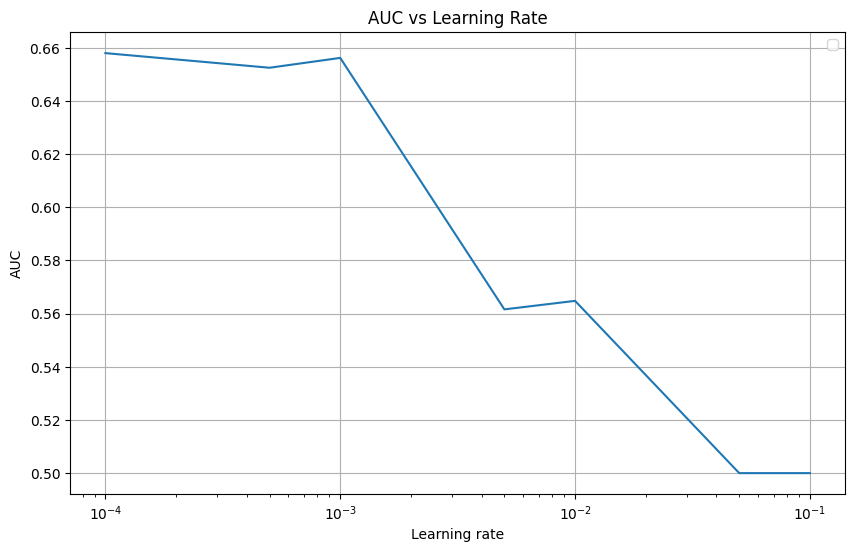

In [ ]:
fig = plt.figure(figsize=(10, 6))
plt.plot(list(auc_dict.keys()), list(auc_dict.values()))
plt.title('AUC vs Learning Rate')
plt.xlabel('Learning rate')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)
plt.xscale('log')
plt.show()

In [ ]:
weights_dict = dict()

for weight in [1.0, 3.0, 5.0, 7.0, 9.0, 11.0, 13.0, 15.0]:
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  CNN = CNN_model().to(device)

  optimizer = torch.optim.Adam(CNN.parameters(), lr=0.001)

  pos_weight = torch.FloatTensor([weight]).to(device)
  criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

  num_epochs = 20
  train_model(CNN, train_loader, criterion, optimizer, device, num_epochs)
  CNN.eval()

  auc_metric = torchmetrics.AUROC(task="binary")

  predictions = []
  actuals = []

  with torch.no_grad():
      for i, l in test_loader:
          i, l = i.to(device), l.to(device)
          outputs = CNN(i)
          # Apply sigmoid to convert logits to probabilities
          predicted_probs = torch.sigmoid(outputs)
          predictions.extend(predicted_probs)
          actuals.extend(l)
          auc_metric.update(predicted_probs, l)
  auc_score = auc_metric.compute()

  print(f'pos-weights = {weight}, The AUC score is: {auc_score:.4f}')
  weights_dict[weight] = auc_score


Epoch 1/20, Loss: 0.0165
Epoch 2/20, Loss: 0.0151
Epoch 3/20, Loss: 0.0149
Epoch 4/20, Loss: 0.0148
Epoch 5/20, Loss: 0.0147
Epoch 6/20, Loss: 0.0146
Epoch 7/20, Loss: 0.0146
Epoch 8/20, Loss: 0.0145
Epoch 9/20, Loss: 0.0144
Epoch 10/20, Loss: 0.0143
Epoch 11/20, Loss: 0.0142
Epoch 12/20, Loss: 0.0141
Epoch 13/20, Loss: 0.0141
Epoch 14/20, Loss: 0.0140
Epoch 15/20, Loss: 0.0139
Epoch 16/20, Loss: 0.0138
Epoch 17/20, Loss: 0.0138
Epoch 18/20, Loss: 0.0137
Epoch 19/20, Loss: 0.0136
Epoch 20/20, Loss: 0.0135
pos-weights = 1.0, The AUC score is: 0.6643
Epoch 1/20, Loss: 0.0351
Epoch 2/20, Loss: 0.0328
Epoch 3/20, Loss: 0.0324
Epoch 4/20, Loss: 0.0319
Epoch 5/20, Loss: 0.0321
Epoch 6/20, Loss: 0.0317
Epoch 7/20, Loss: 0.0316
Epoch 8/20, Loss: 0.0313
Epoch 9/20, Loss: 0.0313
Epoch 10/20, Loss: 0.0311
Epoch 11/20, Loss: 0.0308
Epoch 12/20, Loss: 0.0306
Epoch 13/20, Loss: 0.0305
Epoch 14/20, Loss: 0.0302
Epoch 15/20, Loss: 0.0299
Epoch 16/20, Loss: 0.0297
Epoch 17/20, Loss: 0.0296
Epoch 18/20,

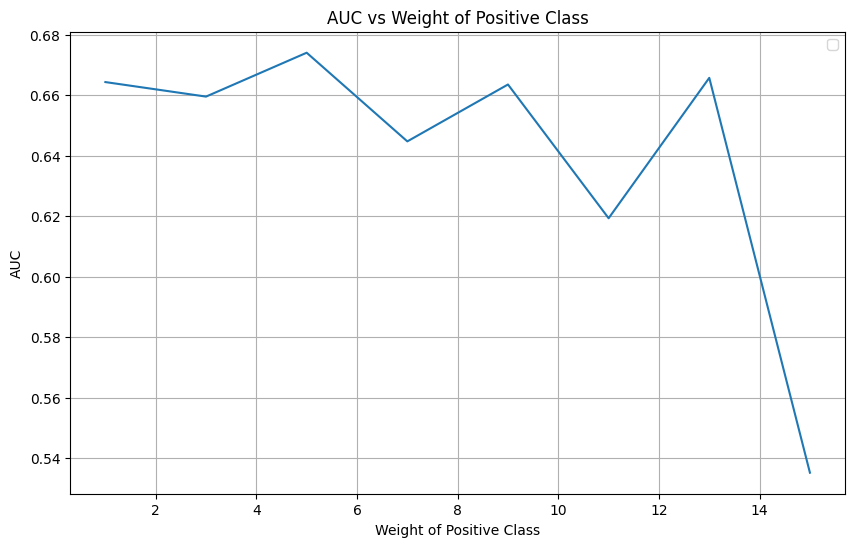

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot([1.0, 3.0, 5.0, 7.0, 9.0, 11.0, 13.0, 15.0], list(weights_dict.values()))
plt.title('AUC vs Weight of Positive Class')
plt.xlabel('Weight of Positive Class')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Final Model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CNN = CNN_model().to(device)

optimizer = torch.optim.Adam(CNN.parameters(), lr=0.001)

pos_weight = torch.FloatTensor([5.0]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

num_epochs = 20
train_model(CNN, train_loader, criterion, optimizer, device, num_epochs)
CNN.eval()

auc_metric = torchmetrics.AUROC(task="binary")

predictions = []
actuals = []

with torch.no_grad():
    for i, l in test_loader:
        i, l = i.to(device), l.to(device)
        outputs = CNN(i)
        # Apply sigmoid to convert logits to probabilities
        predicted_probs = torch.sigmoid(outputs)
        predictions.extend(predicted_probs)
        actuals.extend(l)
        auc_metric.update(predicted_probs, l)
auc_score = auc_metric.compute()

print(f'The AUC score is: {auc_score:.4f}')

Epoch 1/20, Loss: 0.0497
Epoch 2/20, Loss: 0.0455
Epoch 3/20, Loss: 0.0451
Epoch 4/20, Loss: 0.0448
Epoch 5/20, Loss: 0.0444
Epoch 6/20, Loss: 0.0442
Epoch 7/20, Loss: 0.0436
Epoch 8/20, Loss: 0.0436
Epoch 9/20, Loss: 0.0439
Epoch 10/20, Loss: 0.0435
Epoch 11/20, Loss: 0.0436
Epoch 12/20, Loss: 0.0427
Epoch 13/20, Loss: 0.0424
Epoch 14/20, Loss: 0.0420
Epoch 15/20, Loss: 0.0419
Epoch 16/20, Loss: 0.0420
Epoch 17/20, Loss: 0.0416
Epoch 18/20, Loss: 0.0413
Epoch 19/20, Loss: 0.0409
Epoch 20/20, Loss: 0.0406
The AUC score is: 0.6354


### U-Net architecture

#### Tensorflow

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC

def conv_block(input_tensor, num_filters):
    """Function to add two convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(num_filters, (3, 3), activation='relu', padding='same')(input_tensor)
    x = Dropout(0.1)(x)
    # second layer
    x = Conv2D(num_filters, (3, 3), activation='relu', padding='same')(x)
    return x

def encoder_block(input_tensor, num_filters):
    """Function to add two convolutional blocks and then perform max pooling and dropout"""
    x = conv_block(input_tensor, num_filters)
    p = MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(input_tensor, concat_tensor, num_filters):
    """Function to perform upsampling, concatenate skipped connection and two convolutional blocks"""
    x = Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
    x = concatenate([x, concat_tensor], axis=-1)
    x = Dropout(0.1)(x)
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    """Function to build U-Net"""
    inputs = Input(input_shape)

    # Encoder
    c1, p1 = encoder_block(inputs, 64)
    c2, p2 = encoder_block(p1, 128)
    c3, p3 = encoder_block(p2, 256)
    c4, p4 = encoder_block(p3, 512)

    # Bottleneck
    b = conv_block(p4, 1024)

    # Decoder
    d1 = decoder_block(b, c4, 512)
    d2 = decoder_block(d1, c3, 256)
    d3 = decoder_block(d2, c2, 128)
    d4 = decoder_block(d3, c1, 64)

    # Output
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(d4)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [ ]:
# Build U-Net model
unet_model = build_unet((32, 32, 12))
unet_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy', AUC(name='auc')])

In [ ]:
unet_history = unet_model.fit(features, labels, epochs=20, batch_size=16, validation_data=(val_features, val_labels))

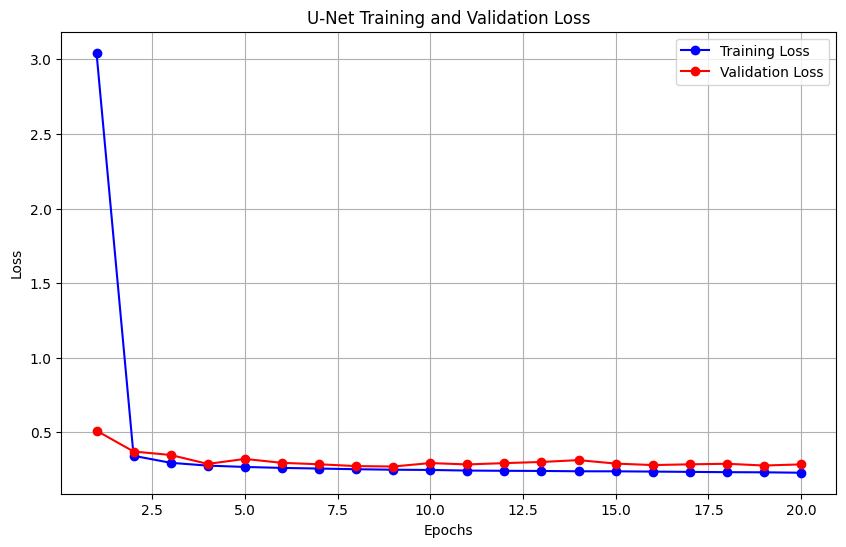

In [ ]:
import matplotlib.pyplot as plt
loss = unet_history.history['loss']
val_loss = unet_history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(10, 6))  # Optional: Adjusts the size of the plot
plt.plot(epochs, loss, label='Training Loss', color='blue', marker='o')
if val_loss is not None:
    plt.plot(epochs, val_loss, label='Validation Loss', color='red', marker='o')

plt.title('U-Net Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)  # Optional: Adds a grid for easier reading
plt.show()

In [ ]:
# model_save_path = '/content/drive/My Drive/Colab Notebooks/my_unet_model.h5'
# # Save model
# unet_model.save(model_save_path)

In [ ]:
# Evaluate on test set
unet_scores = unet_model.evaluate(test_features, test_labels)
print(f'Test Loss: {unet_scores[0]}, Test Accuracy: {unet_scores[1]}, Test AUC: {unet_scores[2]}')

11/11 [==============================] - 3s 110ms/step - loss: 0.2549 - accuracy: 0.9389 - auc: 0.6442
Test Loss: 0.2548823058605194, Test Accuracy: 0.93889981508255, Test AUC: 0.6441639065742493


In [ ]:
# Predictions sur X_train
unet_predicted_masks = unet_model.predict(test_features[:20,:,:,:])

1/1 [==============================] - 2s 2s/step


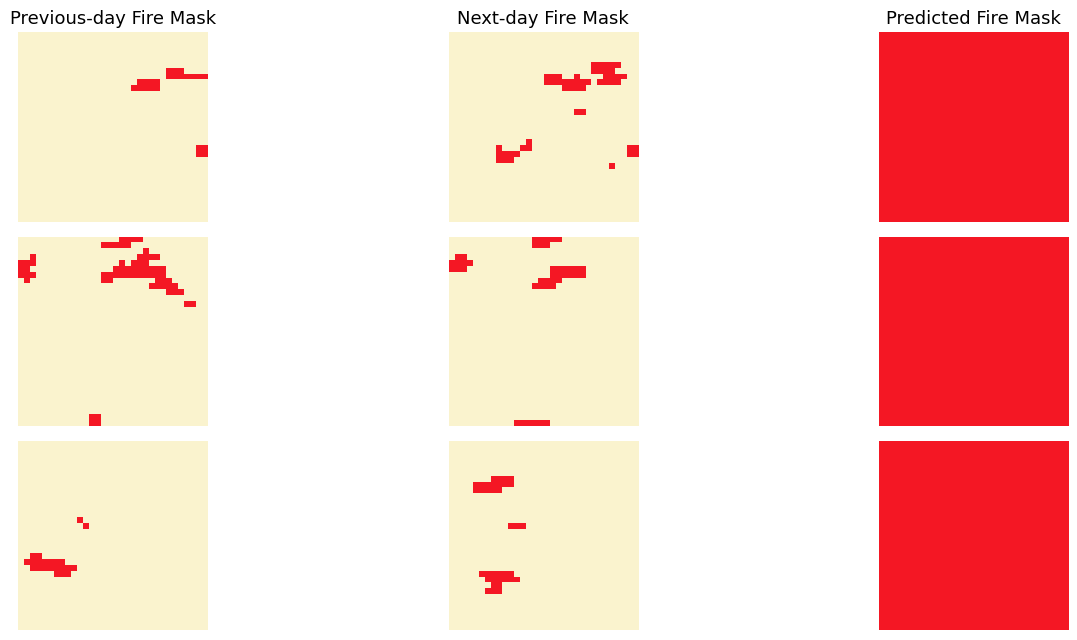

In [ ]:
TITLES_pred = ["Previous-day Fire Mask", "Next-day Fire Mask","Predicted Fire Mask"]
fig = plt.figure(figsize=(15,6.5))
n_rows = 3
n_features = 2
CMAP = colors.ListedColormap(['black', "#FAF3CE", '#F41724'])
BOUNDS = [-1, -0.1, 0.001, 1]
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)

for i in range(n_rows):
  for j in range(n_features + 1):
    plt.subplot(n_rows, n_features+1, i * (n_features+1) + j + 1)
    if i == 0:
      plt.title(TITLES_pred[j], fontsize=13)
    if j == 0:
      plt.imshow(test_features[i, :, :, 11], cmap=CMAP, norm=NORM)
    if j == 1:
      plt.imshow(test_labels[i, :, :, 0], cmap=CMAP, norm=NORM)
    if j == 2:
      plt.imshow(unet_predicted_masks[i,:,:], cmap=CMAP, norm=NORM)
    plt.axis('off')
plt.tight_layout()

#### Torch

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EncoderBlock, self).__init__()
        self.conv_block = ConvBlock(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv_block(x)
        p = self.pool(x)
        return x, p

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super(DecoderBlock, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, middle_channels, kernel_size=2, stride=2)
        self.conv_block = ConvBlock(middle_channels + out_channels, out_channels)

    def forward(self, x, skip):
        x = self.up(x)
        x = torch.cat([x, skip], dim=1)
        x = self.conv_block(x)
        return x

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder1 = EncoderBlock(12, 64)
        self.encoder2 = EncoderBlock(64, 128)
        self.encoder3 = EncoderBlock(128, 256)
        self.encoder4 = EncoderBlock(256, 512)

        self.bottleneck = ConvBlock(512, 1024)

        self.decoder1 = DecoderBlock(1024, 512, 512)
        self.decoder2 = DecoderBlock(512, 256, 256)
        self.decoder3 = DecoderBlock(256, 128, 128)
        self.decoder4 = DecoderBlock(128, 64, 64)

        self.final_conv = nn.Conv2d(64, 1, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Encoder
        c1, p1 = self.encoder1(x)
        c2, p2 = self.encoder2(p1)
        c3, p3 = self.encoder3(p2)
        c4, p4 = self.encoder4(p3)

        # Bottleneck
        b = self.bottleneck(p4)

        # Decoder
        d1 = self.decoder1(b, c4)
        d2 = self.decoder2(d1, c3)
        d3 = self.decoder3(d2, c2)
        d4 = self.decoder4(d3, c1)

        # Output
        output = self.final_conv(d4)
        return output

In [ ]:
# Create dataset
features_tensor = torch.tensor(features, dtype=torch.float32).permute(0, 3, 1, 2) # [batch_size, channels, height, width]
labels_tensor = torch.tensor(labels, dtype=torch.float32).permute(0, 3, 1, 2)

train_dataset = TensorDataset(features_tensor, labels_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=False)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
UNET = UNet().to(device)

optimizer = torch.optim.Adam(UNET.parameters(), lr=0.001)

pos_weight = torch.FloatTensor([3.0]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

num_epochs = 50
train_model(UNET, train_loader, criterion, optimizer, device, num_epochs)

In [ ]:
UNET.eval()
# !pip install torchmetrics
import torch
import torchmetrics
auc_metric = torchmetrics.AUROC(task="binary")

predictions = []
actuals = []

with torch.no_grad():
    for i, l in test_loader:

        outputs = UNET(i)
        predicted_probs = torch.sigmoid(outputs)
        predictions.extend(predicted_probs)
        actuals.extend(l)
        auc_metric.update(predicted_probs, l)
auc_score = auc_metric.compute()

print(f'The AUC score is: {auc_score:.4f}')

The AUC score is: 0.5000


### CNN with Residual Blocks

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, Add

# def ResBlock(x, num_filters, pool=False):
#     """
#     ResBlock as defined in the provided architecture.

#     Parameters:
#     x (tensor): Input tensor into the ResBlock.
#     num_filters (int): Number of filters for the convolutional layers.
#     pool (bool): If True, MaxPooling2D will be used; otherwise Conv2D will be used.

#     Returns:
#     tensor: Output tensor after applying the ResBlock.
#     """
#     #print(x.shape)
#     conv = layers.Conv2D(num_filters, (3, 3), padding='same')(x)
#     #print(conv.shape)

#     x = layers.LeakyReLU(alpha=0.1)(x)
#     x = layers.Dropout(0.5)(x)

#     if pool:
#         x = layers.MaxPooling2D((2, 2))(x)
#         conv = layers.MaxPooling2D((2, 2))(conv)
#         #print(x)
#     else:
#         #print(x)
#         x = layers.Conv2D(num_filters, (3, 3), padding='same')(x)

#     x = layers.Conv2D(num_filters, (3, 3), padding='same')(x)
#     #print(x)
#     x = layers.Dropout(0.5)(x)

#     # Skipping the convolution from the input
#     print(x.shape, conv.shape)
#     x = layers.add([x, conv])
#     print("success")
#     return x

def conv_block(inputs, filters, strides=1):
    x = Conv2D(filters, (3, 3), strides=strides, activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.1)(x)

    return x

def ResBlock(inputs, num_filters):
  x = Conv2D(num_filters, (3, 3), padding='same', strides=(1, 1), activation='relu')(inputs)
  x = Dropout(0.1)(x)
  x = Conv2D(num_filters, (3, 3), padding='same', strides=(1, 1), activation='relu')(x)

  x_compatible = Conv2D(num_filters, (1, 1), strides=(1, 1), padding='same')(inputs)

  x = Add()([x_compatible, x])
  x = Dropout(0.1)(x)
  return x

def build_model(input_shape):
    inputs = Input(input_shape)

    # Initial Convolutional Block
    x = conv_block(inputs, 16)

    # First set of layers with 16 filters
    x = conv_block(x, 16)

    # First Residual Block with 32 filters
    x = ResBlock(x, 32)

    # Second Residual Block with 32 filters
    x = ResBlock(x, 32)

    # Upsampling + Conv2D Transpose
    x = Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)

    # Final Convolutional Layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x)

    model = Model(inputs, outputs)
    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model
CNN_res = build_model((32, 32, 12))
CNN_res.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 32, 32, 12)]         0         []                            
                                                                                                  
 conv2d_39 (Conv2D)          (None, 32, 32, 16)           1744      ['input_6[0][0]']             
                                                                                                  
 max_pooling2d_11 (MaxPooli  (None, 16, 16, 16)           0         ['conv2d_39[0][0]']           
 ng2D)                                                                                            
                                                                                                  
 dropout_26 (Dropout)        (None, 16, 16, 16)           0         ['max_pooling2d_11[0][0]

In [ ]:
class_weight = {0: 1., 1: 3.}  # 1 is the 'fire' class
CNN_res.fit(features, labels, batch_size=8, epochs=100, class_weight=class_weight)

Epoch 1/100
354/354 [==============================] - 23s 23ms/step - loss: 15.0609 - accuracy: 0.6439
Epoch 2/100
354/354 [==============================] - 5s 13ms/step - loss: 1.1872 - accuracy: 0.8016
Epoch 3/100
354/354 [==============================] - 5s 15ms/step - loss: 0.7653 - accuracy: 0.8995
Epoch 4/100
354/354 [==============================] - 4s 11ms/step - loss: 0.6914 - accuracy: 0.9203
Epoch 5/100
354/354 [==============================] - 3s 7ms/step - loss: 0.6471 - accuracy: 0.9267
Epoch 6/100
354/354 [==============================] - 3s 7ms/step - loss: 0.6197 - accuracy: 0.9297
Epoch 7/100
354/354 [==============================] - 3s 10ms/step - loss: 0.5988 - accuracy: 0.9315
Epoch 8/100
354/354 [==============================] - 3s 8ms/step - loss: 0.5807 - accuracy: 0.9326
Epoch 9/100
354/354 [==============================] - 3s 8ms/step - loss: 0.5676 - accuracy: 0.9333
Epoch 10/100
354/354 [==============================] - 3s 7ms/step - loss: 0.5562 -

In [ ]:
res_predicted_masks = CNN_res.predict(test_features)

11/11 [==============================] - 0s 3ms/step


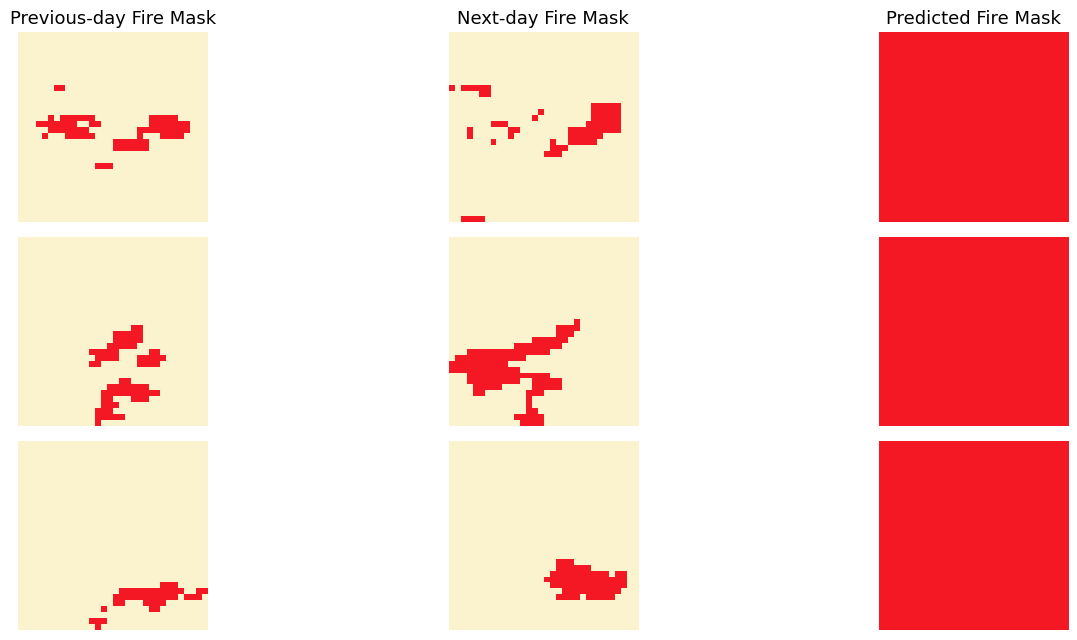

In [ ]:
TITLES_pred = ["Previous-day Fire Mask", "Next-day Fire Mask","Predicted Fire Mask"]
fig = plt.figure(figsize=(15,6.5))
n_rows = 3
n_features = 2
CMAP = colors.ListedColormap(['black', "#FAF3CE", '#F41724'])
BOUNDS = [-1, -0.1, 0.001, 1]
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)

for i in range(n_rows):
  for j in range(n_features + 1):
    plt.subplot(n_rows, n_features+1, i * (n_features+1) + j + 1)
    if i == 0:
      plt.title(TITLES_pred[j], fontsize=13)
    if j == 0:
      plt.imshow(test_features[i, :, :, 11], cmap=CMAP, norm=NORM)
    if j == 1:
      plt.imshow(test_labels[i, :, :, 0], cmap=CMAP, norm=NORM)
    if j == 2:
      plt.imshow(res_predicted_masks[i,:,:], cmap=CMAP, norm=NORM)
    plt.axis('off')
plt.tight_layout()